# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Чтение данных**

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

**Общая информация**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Приведем значения столбцов для удобства к lowercase

In [6]:
df.columns = df.columns.str.lower()

**Удаление дубликатов**

In [7]:
df.duplicated().sum()

4

In [8]:
df = df.drop_duplicates().reset_index(drop=True)

**Удаление неинформативных столбцов**

In [9]:
df= df.drop(columns=['numberofpictures','postalcode','datecrawled','registrationmonth','datecreated','lastseen'])

**Работа с пропусками**

In [10]:
df.isna().mean() * 100

price                0.000000
vehicletype         10.579487
registrationyear     0.000000
gearbox              5.596772
power                0.000000
model                5.560651
kilometer            0.000000
fueltype             9.282802
brand                0.000000
notrepaired         20.079297
dtype: float64

Имеется большое количество пропусков в столбцах vehicletype, gearbox, model, fueltype, notrepaired

In [11]:
columns_missing_values = ['vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired']
for column in columns_missing_values:
    print(column, df[column].unique())


vehicletype [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
gearbox ['manual' 'auto' nan]
model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

В столбце vehicletype,fueltype,model есть категория other, поэтому можно пропущенные значения заменить на эту категорию.
В столбце notrepaired целезообразно заменить на yes, руководствуясь логикой, что при продаже владельцы машин, не подвергавшихся ремонту, будут указывать это охотнее.


In [12]:
df['vehicletype'] = df['vehicletype'].fillna(value='other') 
df['fueltype'] = df['fueltype'].fillna(value='other') 
df['model'] = df['model'].fillna(value='other') 
df['notrepaired'] = df['notrepaired'].fillna('yes')

Заменим пропущенные значения в столбце gearbox в зависимости от модели машины

In [13]:
df.loc[df['gearbox'].isna(), 'gearbox'] = df.loc[df['gearbox'].isna(), 'model'].map(df.groupby('model')['gearbox'].first())

In [14]:
df.isna().sum().sum()

0

<div class="alert alert-block alert-success">
<b>Успех:</b> Заполнить пропуски таким образом – достаточно безопасное решение.
</div>

**Проверка выборки на выбросы**

In [15]:
df.describe()

,price,registrationyear,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Удалим выбросы в столбце registrationyear	

In [16]:
df['registrationyear'].quantile(.01)

1980.0

In [17]:
df['registrationyear'].quantile(.99)

2018.0

In [18]:
df = df.drop(df[df['registrationyear'] > 2018].index,axis=0)

In [19]:
df = df.drop(df[df['registrationyear'] < 1980].index,axis=0)

In [20]:
len(df)

350783

In [21]:
df.describe()

,price,registrationyear,power,kilometer
count,350783.000000,350783.000000,350783.000000,350783.000000
mean,4394.199636,2003.421936,110.422178,128681.578070
std,4494.780074,6.610276,188.276281,37412.836793
min,0.000000,1980.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6300.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2018.000000,20000.000000,150000.000000


Избавимся от выбросов в столбце power

In [22]:
df['power'].quantile(0.99)

300.0

In [23]:
df = df.drop(df[df['power'] > 300].index,axis=0)

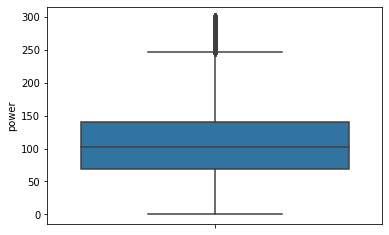

In [24]:
ax = sns.boxplot(y="power", data=df)

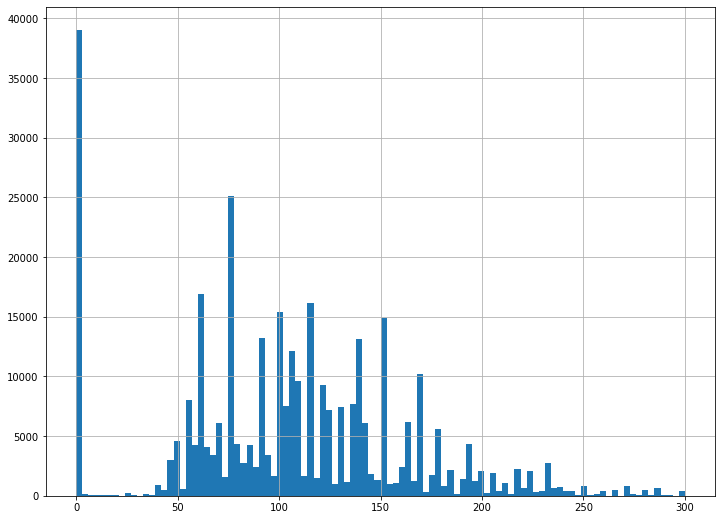

In [25]:
df.query('0 <= power < 301')['power'].hist(bins=100, figsize=(12,9))
plt.show()

In [26]:
df['power'].describe()

count    347350.000000
mean        104.772063
std          59.083766
min           0.000000
25%          69.000000
50%         103.000000
75%         140.000000
max         300.000000
Name: power, dtype: float64

In [27]:
len(df)

347350

10% данных имеют нулевые значения, заменим их на медианные в зависимости от модели

In [28]:
len(df.loc[df['power']==0])

38999

In [29]:
mapping = pd.Series(df.groupby('model')['power'].median()).to_dict()

In [30]:
df.loc[df['power']==0,'power']=df['model'].map(mapping)

In [31]:
len(df.loc[df['power']==0])

26

In [32]:
df = df.drop(df[df['power'] ==0].index,axis=0)

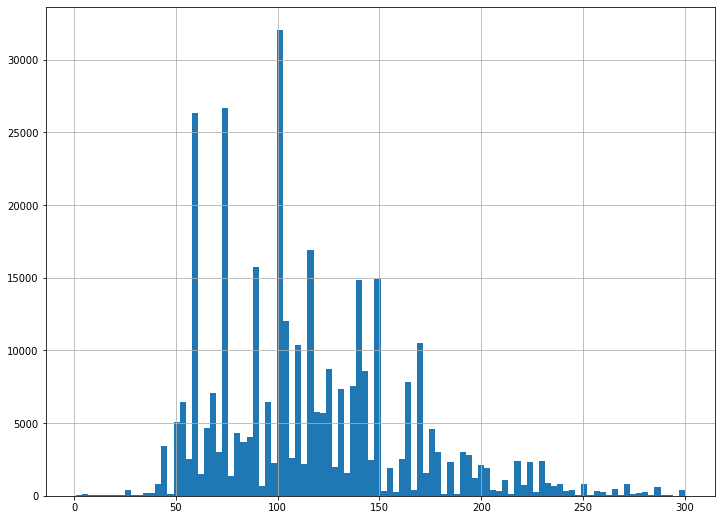

In [33]:
df.query('0 <= power < 301')['power'].hist(bins=100, figsize=(12,9))
plt.show()

In [34]:
df['power'].describe()

count    347324.000000
mean        116.289404
std          47.517702
min           1.000000
25%          75.000000
50%         107.000000
75%         143.000000
max         300.000000
Name: power, dtype: float64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347324 entries, 0 to 354364
Data columns (total 10 columns):
price               347324 non-null int64
vehicletype         347324 non-null object
registrationyear    347324 non-null int64
gearbox             347324 non-null object
power               347324 non-null float64
model               347324 non-null object
kilometer           347324 non-null int64
fueltype            347324 non-null object
brand               347324 non-null object
notrepaired         347324 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 29.1+ MB


Таким образом из всей выборки выбросили всего ~7000 записей

**Кодирование переменных**

In [36]:
df['power']=df['power'].astype(int)

In [37]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,other,1993,manual,95,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [38]:
encoder = OrdinalEncoder()
df_ordinal = df.copy()
df_ordinal[['vehicletype','gearbox','model','fueltype','brand','notrepaired']] = encoder.fit_transform(df_ordinal[['vehicletype','gearbox','model','fueltype','brand','notrepaired']]).astype(np.int) 


In [39]:
df_ordinal.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,3,1993,1,95,116,150000,6,38,1
1,18300,2,2011,1,190,166,125000,2,1,1
2,9800,6,2004,0,163,117,125000,2,14,1
3,1500,5,2001,1,75,116,150000,6,38,0
4,3600,5,2008,1,69,101,90000,2,31,0


Наши данные подготовлены, можно приступать к обучению

## Обучение моделей

**Разбиение выборки**

In [40]:
categoricals = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']

In [41]:
features = df_ordinal.drop(['price'],axis=1)
target = df_ordinal['price']

In [42]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [43]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [44]:
print('Размер обучающей выборки:', features_train.shape[0])
print('Размер валидационной выборки:', features_valid.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])

Размер обучающей выборки: 208394
Размер валидационной выборки: 69465
Размер тестовой выборки: 69465


**На этом шаге подберем оптимальные параметры для всех моделей, минимизируя rmse при помощи GridSearchCV**

In [45]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

### Linear Regression

In [46]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
predicted_valid = linear_model.predict(features_valid)

CPU times: user 69.2 ms, sys: 12.2 ms, total: 81.4 ms
Wall time: 69.6 ms


### Decision Tree Regressoion

In [47]:

hyperparams = { 'max_depth':[x for x in range(2, 16)],
                'random_state':[12345],
                'min_samples_split': np.arange(2,20,2),
                'min_samples_leaf':range(1,5)}

In [48]:
%%time
tree_model = DecisionTreeRegressor()
clf = GridSearchCV(tree_model, hyperparams, scoring=rmse_scorer)
clf.fit(features_train, target_train)
clf.best_params_


CPU times: user 6min 13s, sys: 85.9 ms, total: 6min 13s
Wall time: 6min 14s


{'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 18,
 'random_state': 12345}

### Random Forest Regression

In [49]:
%%time
forest_model = RandomForestRegressor()
hyperparams = {'max_depth':[x for x in range(2, 16)],
               'random_state':[12345],
               'min_samples_split': np.arange(2,20,2),
               'min_samples_leaf':range(1,5)}

clf = GridSearchCV(tree_model, hyperparams, scoring=rmse_scorer)
clf.fit(features_train, target_train)
clf.best_params_
# forest_model.get_params().keys()

CPU times: user 6min 14s, sys: 236 ms, total: 6min 14s
Wall time: 6min 16s


{'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 18,
 'random_state': 12345}

### Ridge Regression

In [50]:
%%time
ridge_model = Ridge()
hyperparams = {'alpha': [1,0.1,0.01,0.001,0.0001,0],
               'solver' :['auto', 'svd', 'cholesky']}
clf = GridSearchCV(ridge_model, hyperparams, scoring=rmse_scorer)
clf.fit(features_train, target_train)
clf.best_params_


CPU times: user 7.1 s, sys: 5.59 s, total: 12.7 s
Wall time: 12.7 s


{'alpha': 1, 'solver': 'svd'}

In [51]:
features_train

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
101870,5,2002,1,101,103,150000,6,10,0
43829,5,1990,1,90,116,150000,6,38,1
307344,3,2018,1,184,239,5000,4,2,1
280327,5,2000,1,60,176,125000,6,9,0
60730,7,2012,1,143,116,60000,6,38,0
...,...,...,...,...,...,...,...,...,...
162051,4,2006,1,163,6,150000,2,2,0
48804,5,1997,1,58,225,5000,5,27,1
88059,4,2000,1,101,28,150000,6,1,0
78760,7,1989,1,83,166,150000,6,39,1


### Cat Boost Regression

In [52]:
%%time
cat_model = CatBoostRegressor(cat_features=categoricals,iterations=200,logging_level = 'Info')

hyperparams = {'depth': [3, 10],
          'loss_function': ['RMSE'],
          'learning_rate':np.arange(0.1,1,0.2),
          'random_seed': [12345]
         }

clf= GridSearchCV(estimator=cat_model, param_grid=hyperparams, scoring=rmse_scorer)
clf.fit(features_train, target_train)
clf.best_params_


registrationyear, bin=25 score 937082.6242
power, bin=102 score 1126230.237
registrationyear, bin=35 score 1204675.167
0:	learn: 4207.2182169	total: 164ms	remaining: 32.7s

registrationyear, bin=24 score 833954.3864
{vehicletype} pr2 tb0 type0, border=5 score 1014488.292
power, bin=135 score 1100982.358
1:	learn: 4007.0507842	total: 281ms	remaining: 27.8s

registrationyear, bin=25 score 764900.8009
{vehicletype} pr1 tb0 type0, border=5 score 936869.4959
power, bin=136 score 1006408.343
2:	learn: 3830.6381594	total: 468ms	remaining: 30.7s

registrationyear, bin=26 score 688951.0389
{vehicletype} pr1 tb0 type0, border=6 score 867275.7906
power, bin=137 score 935866.9762
3:	learn: 3671.9384768	total: 569ms	remaining: 27.9s

registrationyear, bin=23 score 644607.6046
power, bin=98 score 773874.5841
kilometer, bin=10 score 886258.1088
4:	learn: 3523.1739592	total: 765ms	remaining: 29.8s

registrationyear, bin=23 score 570092.5776
power, bin=136 score 693482.7257
kilometer, bin=11 score 786

{'depth': 10,
 'learning_rate': 0.30000000000000004,
 'loss_function': 'RMSE',
 'random_seed': 12345}

### LGBM Regression

In [53]:
%%time
lgbm_model = lgb.LGBMRegressor(categorical_features = categoricals,vervose=1)

hyperparams = {'max_depth': [5, 10],
          'n_estimators': [50,150,100,200],
          'random_state': [12345]
         }
clf= GridSearchCV(estimator=lgbm_model, param_grid=hyperparams, scoring=rmse_scorer, cv=5)
clf.fit(features_train, target_train)
clf.best_params_

CPU times: user 4min 28s, sys: 941 ms, total: 4min 29s
Wall time: 4min 34s


{'max_depth': 10, 'n_estimators': 200, 'random_state': 12345}

## Анализ моделей

### Linear Regression

In [54]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)


CPU times: user 47.8 ms, sys: 8.62 ms, total: 56.4 ms
Wall time: 113 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
%%time
predicted_valid = linear_model.predict(features_valid)

CPU times: user 482 µs, sys: 8.48 ms, total: 8.96 ms
Wall time: 2.68 ms


In [56]:
rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
rmse

2948.0209859538545

In [57]:
%%time
predicted_test= linear_model.predict(features_test)

CPU times: user 5.01 ms, sys: 354 µs, total: 5.36 ms
Wall time: 2.54 ms


In [58]:
linear_test_rmse = (mean_squared_error(target_test, predicted_test))**0.5
linear_test_rmse

2940.023386328952

### Decision Tree Regressoion

In [59]:
%%time
tree_model = DecisionTreeRegressor(max_depth = 15, 
                                   min_samples_leaf=4,
                                   min_samples_split=18,
                                   random_state=12345)
tree_model.fit(features_train, target_train)

CPU times: user 540 ms, sys: 0 ns, total: 540 ms
Wall time: 539 ms


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=18, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [60]:
%%time
predicted_valid  = tree_model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
rmse

CPU times: user 15.6 ms, sys: 173 µs, total: 15.7 ms
Wall time: 14.4 ms


1892.0539637593372

In [61]:
%%time
predicted_test = tree_model.predict(features_test)
rmse = (mean_squared_error(target_test, predicted_test))**0.5
rmse

CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 30.9 ms


1911.725119026124

### Random Forest Regression

In [62]:
%%time
forest_model = RandomForestRegressor(max_depth = 15,
                                     min_samples_leaf = 4,
                                     min_samples_split = 18,
                                     random_state = 12345)
forest_model.fit(features_train, target_train)

CPU times: user 3.69 s, sys: 0 ns, total: 3.69 s
Wall time: 3.8 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=18,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [63]:
%%time
predicted_valid  = forest_model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
rmse

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 115 ms


1772.4463421315563

In [64]:
%%time
predicted_test = forest_model.predict(features_test)
rmse = (mean_squared_error(target_test, predicted_test))**0.5
rmse

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 116 ms


1779.8111030789696

### Ridge Regression

In [65]:
%%time
ridge_model = Ridge(alpha = 1,fit_intercept = True,solver = 'svd')
ridge_model.fit(features_train, target_train)



CPU times: user 86.4 ms, sys: 3.99 ms, total: 90.4 ms
Wall time: 63.4 ms


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='svd', tol=0.001)

In [66]:
%%time
predicted_valid  = ridge_model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
rmse

CPU times: user 6.85 ms, sys: 12.3 ms, total: 19.1 ms
Wall time: 4.45 ms


2948.021113217624

In [67]:
%%time
predicted_test = ridge_model.predict(features_test)
rmse = (mean_squared_error(target_test, predicted_test))**0.5
rmse

CPU times: user 42.1 ms, sys: 27.2 ms, total: 69.3 ms
Wall time: 96.2 ms


2940.023368612869

### Cat Boost Regression

In [68]:
%%time
cat_model = CatBoostRegressor(depth = 10, learning_rate = 0.3, loss_function= 'RMSE', random_seed= 12345,cat_features=categoricals)
cat_model.fit(features_train, target_train)

0:	learn: 3517.1440992	total: 616ms	remaining: 10m 15s
1:	learn: 2918.2951041	total: 1.33s	remaining: 11m 3s
2:	learn: 2535.7593850	total: 2.12s	remaining: 11m 46s
3:	learn: 2293.9372536	total: 2.92s	remaining: 12m 7s
4:	learn: 2145.0536931	total: 3.71s	remaining: 12m 18s
5:	learn: 2035.6810638	total: 4.32s	remaining: 11m 56s
6:	learn: 1966.0751444	total: 5.02s	remaining: 11m 51s
7:	learn: 1917.3780909	total: 5.91s	remaining: 12m 13s
8:	learn: 1889.4232601	total: 6.71s	remaining: 12m 18s
9:	learn: 1865.1906819	total: 7.42s	remaining: 12m 14s
10:	learn: 1850.8564922	total: 8.11s	remaining: 12m 8s
11:	learn: 1836.4663984	total: 8.78s	remaining: 12m 2s
12:	learn: 1823.6947943	total: 9.49s	remaining: 12m
13:	learn: 1813.6067044	total: 10.2s	remaining: 11m 57s
14:	learn: 1799.8236036	total: 10.9s	remaining: 11m 54s
15:	learn: 1791.0885459	total: 11.4s	remaining: 11m 40s
16:	learn: 1782.7998594	total: 12.1s	remaining: 11m 38s
17:	learn: 1776.7214159	total: 12.9s	remaining: 11m 42s
18:	learn:

In [69]:
%%time
predicted_valid  = cat_model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
rmse

CPU times: user 2.64 s, sys: 187 ms, total: 2.82 s
Wall time: 3.01 s


1656.6965416916985

In [70]:
%%time
predicted_test = cat_model.predict(features_test)
rmse = (mean_squared_error(target_test, predicted_test))**0.5
rmse

CPU times: user 2.6 s, sys: 0 ns, total: 2.6 s
Wall time: 2.59 s


1644.5513236481

### LGBM Regression

In [71]:
%%time
lgbm_model = lgb.LGBMRegressor(max_depth = 10,n_estimators=200,random_state=1234,categorical_features = categoricals,vervose=1)
lgbm_model.fit(features_train, target_train)

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.5 s


LGBMRegressor(boosting_type='gbdt',
              categorical_features=['vehicletype', 'gearbox', 'model',
                                    'fueltype', 'brand', 'notrepaired'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.1, max_depth=10, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
              n_jobs=-1, num_leaves=31, objective=None, random_state=1234,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, vervose=1)

In [72]:
%%time
predicted_valid  = lgbm_model.predict(features_valid)
rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
rmse

CPU times: user 855 ms, sys: 0 ns, total: 855 ms
Wall time: 892 ms


1732.5757276563802

In [73]:
%%time
predicted_test = lgbm_model.predict(features_test)
rmse = (mean_squared_error(target_test, predicted_test))**0.5
rmse

CPU times: user 857 ms, sys: 0 ns, total: 857 ms
Wall time: 890 ms


1741.2088874062483

| model      | Linear Regression | Decision Tree Regressoion | Random Forest Regression | Ridge Regression | Cat Boost Regression | LGBM Regression |
|------------|-------------------|---------------------------|--------------------------|------------------|----------------------|-----------------|
| rmse valid | 2948.02           | 1892.05                   | 1772.45                  | 2948.02          | 1656.70              | 1732,57         |
| rmse test  | 2940.02           | 1911.72                   | 1779.81                  | 2940.02          | 1644.5              | 1741.20         |
| CPU times training  | 67.6 ms           | 623 ms                    | 4.26 s                   | 157 ms           | 3min 35s             | 12.9 s          |
| CPU times validation | 2.58 ms            | 13.9 ms                    | 105 ms                   | 25.2 ms           | 2.56 s              | 883 ms          |                                                                      |

## Выводы

***Наиболее точные*** результаты прогнозирования показала модель **Cat Boost**. Самые быстрые в плане обучения модели - линейные (Linear Regression, Ridge Regression). Они так же показали самые худшие результаты прогнозирования.  ***Самым оптимальным*** в плане скорости обучения и rmse метрики является **Random Forest**, результаты прогнозирования на тестовой выборке близки к **LGBM Regression**, но скорость обучения в 3 раз выше. Таким образом, на данной выборке если важна наибольшая точность прогноза в не зависисимости от времени, то следует выбрать **Cat Boost**, если можно пожертвовать точностью прогнозирования в сторону быстродействия - **Random Forest**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей